# NLP, seq2seq
* one to many
* one to one
* many to one
* many to many
* many to many () 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0e393f5c-bf69-e469-f3e5-93f3bec377f1)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses
from helper_functions import plot_loss_curves, compare_historys, unzip_data, create_tensorboard_callback

--2023-03-04 11:07:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-04 11:07:49 (103 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## get the dataset kaggle get started with NLP

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data('nlp_getting_started.zip')

--2023-03-04 11:07:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-04 11:07:53 (127 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



## visualizing the data 
* tf Load test
* pandas (needs a lot of memory)
* python

In [4]:
import pandas as pd
train_df, test_df = pd.read_csv('train.csv'), pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')
train_df, test_df, sample_submission_df

(         id keyword location  \
 0         1     NaN      NaN   
 1         4     NaN      NaN   
 2         5     NaN      NaN   
 3         6     NaN      NaN   
 4         7     NaN      NaN   
 ...     ...     ...      ...   
 7608  10869     NaN      NaN   
 7609  10870     NaN      NaN   
 7610  10871     NaN      NaN   
 7611  10872     NaN      NaN   
 7612  10873     NaN      NaN   
 
                                                    text  target  
 0     Our Deeds are the Reason of this #earthquake M...       1  
 1                Forest fire near La Ronge Sask. Canada       1  
 2     All residents asked to 'shelter in place' are ...       1  
 3     13,000 people receive #wildfires evacuation or...       1  
 4     Just got sent this photo from Ruby #Alaska as ...       1  
 ...                                                 ...     ...  
 7608  Two giant cranes holding a bridge collapse int...       1  
 7609  @aria_ahrary @TheTawniest The out of control w...       1  

In [5]:
# 1 for disaster
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
# shuffle if the data is not sequential
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# tf imbalanced classification
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[['text', 'target']][random_index: random_index + 5].itertuples():
  _, text, target = row
  print(f'target: {target}', '(real disaster)' if target > 0 else '(not a real disaster)')
  print(f'Text: \n{text}\n')
  print('___\n')

target: 1 (real disaster)
Text: 
I was taught at school in the 1970s that piracy slavery and suicide-bombing were purely historical. No one then expected them to re-occur

___

target: 1 (real disaster)
Text: 
Petition/No Medals for 1890 Massacre Justice for Wounded Knee Killings of Native Americans! http://t.co/UilPg8i1ev http://t.co/m9pXTo2kwW

___

target: 1 (real disaster)
Text: 
70 years since we annihilated 100000 people instantly and became aware that we have the ability to annihilate the whole of humanity

___

target: 0 (not a real disaster)
Text: 
@_DANGdaddy the sirens are telling you to get ready to TURN UP???????? http://t.co/qAQqrJv9gU

___

target: 1 (real disaster)
Text: 
KATUNews: #SR14 remains closed as brush fire burns 1700 acres: http://t.co/QposKp3MWj #LiveOnK2 http://t.co/mTQjsvupwy

___



## split the data 

In [10]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), 
                                                                            train_df_shuffled['target'].to_numpy(), 
                                                                            test_size=.1,
                                                                            random_state=42)
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [11]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## tokenization + embedding

### text vectorization (tokenization)

In [12]:
from tensorflow.keras.layers import TextVectorization
text_vectorier = TextVectorization(max_tokens=None, # <OOV>
                                   standardize='lower_and_strip_punctuation',
                                   split='whitespace',
                                   ngrams=None, 
                                   output_mode='int',
                                   output_sequence_length=None)

In [13]:
# average number of tokens in training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [14]:
# set the text vectorization variables
max_vocab_length = 10000
max_length = 15         # how many of words of the tweet will our model see
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [15]:
text_vectorizer.adapt(train_sentences)

In [16]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [17]:
# create a sample text and tokenizer
sample_sentence = 'There is a flood out there.'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,  36,  74,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [18]:
# random sentence from train_sentences
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\nVectorized version:\n')
text_vectorizer([random_sentence])

Original text:
 http://t.co/x1x6d5Enef Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/XhehJFFT7g      

Vectorized version:



<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  835,  260, 1147, 1114,  935,  714,  745,  459,  647,    1,
           0,    0,    0,    0]])>

In [19]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Embedding layer

In [20]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            input_length=max_length,
                            embeddings_initializer='uniform')
embedding

In [21]:
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\nEmbedded version:\n')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Cameroon Repatriated 12000 Nigerian Refugees http://t.co/6nQRU2q5Tz      

Embedded version:



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00070632, -0.01440489,  0.01979068, ..., -0.02932822,
          0.04376281, -0.01606338],
        [ 0.04728815,  0.03943224, -0.0290063 , ..., -0.04432721,
         -0.04274181, -0.04513692],
        [-0.04988862,  0.00680185, -0.04959689, ...,  0.04808767,
         -0.00946533,  0.00226346],
        ...,
        [ 0.01683129, -0.0141327 , -0.01178567, ..., -0.01014887,
         -0.01000123,  0.01468215],
        [ 0.01683129, -0.0141327 , -0.01178567, ..., -0.01014887,
         -0.01000123,  0.01468215],
        [ 0.01683129, -0.0141327 , -0.01178567, ..., -0.01014887,
         -0.01000123,  0.01468215]]], dtype=float32)>

In [22]:
# single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00070632, -0.01440489,  0.01979068, -0.01083327, -0.02167882,
        -0.03264662,  0.02905673, -0.02667388,  0.02501902,  0.03480371,
        -0.0355829 , -0.03274773, -0.01325018, -0.04770395,  0.03388144,
         0.02164865, -0.00213706,  0.04106769, -0.0422053 , -0.0257812 ,
         0.00678553, -0.009564  ,  0.04152444,  0.04774411, -0.04534743,
         0.02693186,  0.0246907 , -0.04847651, -0.00203431, -0.02232455,
         0.00426932,  0.01336283, -0.01691424, -0.0373481 ,  0.02714386,
        -0.04654175,  0.03747406, -0.03705332,  0.011261  , -0.01829628,
         0.00638207, -0.03499325,  0.01051454, -0.00996035,  0.02641419,
         0.00242801, -0.03883885, -0.03034708,  0.01207373, -0.02988814,
        -0.0053665 , -0.02280702,  0.00929445, -0.01598754, -0.00774171,
        -0.0004459 , -0.00320368, -0.02991177, -0.02257545, -0.0049559 ,
         0.01943258,  0.00589275,  0.03947803,  0.04729814, -0.0201685 ,
  

## modeling a text dataset and experiment

## baseline

* model_0 naive bayes 
* model_1 ffn 
* model_2 lstm
* model_3 gru
* model_4 bi-lstm
* model_5 1d conv
* model_6 tensorflow_hub transfer learning (feature extractor)
* model_7 transfer learning on 10% data

* **steps**
* create a model
* build the model
* fit the model
* evaluate

In [23]:
# model_0 base line
# multinomial naive bayes with tf-idf formula
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieved accuracy of {baseline_score*100:.2f}')

Our baseline model achieved accuracy of 79.27


In [25]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [26]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
classification_report_dict = classification_report(val_labels, baseline_preds, output_dict=True)
classification_report_dict

{'0': {'precision': 0.748062015503876,
  'recall': 0.9323671497584541,
  'f1-score': 0.8301075268817204,
  'support': 414},
 '1': {'precision': 0.8861788617886179,
  'recall': 0.6264367816091954,
  'f1-score': 0.734006734006734,
  'support': 348},
 'accuracy': 0.7926509186351706,
 'macro avg': {'precision': 0.817120438646247,
  'recall': 0.7794019656838247,
  'f1-score': 0.7820571304442272,
  'support': 762},
 'weighted avg': {'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1-score': 0.7862189758049549,
  'support': 762}}

In [28]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy':model_accuracy,
                   'precision':model_precision,
                   'recall':model_recall,
                   'f1':model_f1_score}
  return model_results

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [30]:
from tensorflow_addons.metrics import F1Score
from helper_functions import calculate_results, create_tensorboard_callback
# tensorboard callback
SAVE_DIR = 'model_logs'

## model_1 FFN

In [31]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
 # solve the shape error with GlobalAveragePooling1D or Flatten or GlobalMaxPool1D layers
x = layers.GlobalAveragePooling1D(name='gobal_average_pooling_1d')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gobal_average_pooling_1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [32]:
embedding, text_vectorizer

(<keras.layers.core.embedding.Embedding at 0x7f1f01908820>,
 <keras.layers.preprocessing.text_vectorization.TextVectorization at 0x7f1f0bb49430>)

In [33]:
# compile
model_1.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [34]:
train_labels.shape, train_sentences.shape, train_labels.dtype, train_labels.ndim, 

((6851,), (6851,), dtype('int64'), 1)

In [35]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230304-110806
Epoch 1/5
215/215 [==============================] - 25s 106ms/step - loss: 0.6126 - accuracy: 0.6901 - val_loss: 0.5384 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.4429 - accuracy: 0.8174 - val_loss: 0.4700 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3479 - accuracy: 0.8615 - val_loss: 0.4583 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2851 - accuracy: 0.8902 - val_loss: 0.4653 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2379 - accuracy: 0.9140 - val_loss: 0.4778 - val_accuracy: 0.7861


In [36]:
model_1_results = model_1.evaluate(val_sentences, val_labels)
model_1_results

24/24 [==============================] - 0s 6ms/step - loss: 0.4778 - accuracy: 0.7861


[0.47779062390327454, 0.7860892415046692]

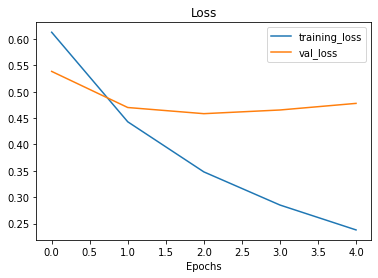

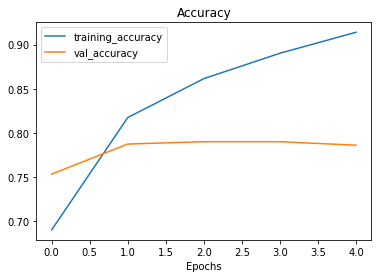

In [37]:
plot_loss_curves(model_1_history)

In [38]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10], model_1_pred_probs.shape

24/24 [==============================] - 0s 4ms/step


(array([[0.39632738],
        [0.79127795],
        [0.99812835],
        [0.10885105],
        [0.10639276],
        [0.93308055],
        [0.9231012 ],
        [0.99091244],
        [0.9663467 ],
        [0.2338082 ]], dtype=float32), (762, 1))

In [39]:
# convert model_pred_probs to model_preds
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10], model_1_preds.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>,
 TensorShape([762]))

In [40]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [41]:
from scipy.optimize.zeros import results_c
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

<ipython-input-41-7a658b99b0f6>:1: DeprecationWarning: Please use `results_c` from the `scipy.optimize` namespace, the `scipy.optimize.zeros` namespace is deprecated.
  from scipy.optimize.zeros import results_c


array([False, False, False, False])

###visualizing learned embeddings

In [42]:
# get the voacabulary
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gobal_average_pooling_1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [44]:
# weight matrix of embdding layer
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[ 0.03677093, -0.0344649 , -0.03126734, ...,  0.00731529,
        -0.03021784,  0.03361623],
       [ 0.05224537, -0.00723979, -0.0562797 , ..., -0.0090783 ,
        -0.05175633, -0.02230622],
       [-0.00223279, -0.04772342, -0.06010299, ...,  0.01329636,
         0.0030212 , -0.02727169],
       ...,
       [ 0.00781167, -0.03845693, -0.00715087, ..., -0.04059593,
         0.01516527, -0.00305488],
       [ 0.05840106, -0.07162051, -0.04325327, ...,  0.06338096,
        -0.03341275,  0.08083518],
       [ 0.08371906, -0.08657576, -0.060878  , ...,  0.07105688,
        -0.07591768,  0.099422  ]], dtype=float32)

In [45]:
print(embed_weights.shape)

(10000, 128)


* projector.tensorflow.org

In [46]:
# create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
# dowbload from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model_2 LSTM

In [48]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [49]:
# lstm model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_lstm")
model_2.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [50]:
model_2, train_sentences, train_labels

(<keras.engine.functional.Functional at 0x7f1f001f52b0>,
 array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        ...,
        'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
        "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
        "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
       dtype=object),
 array([0, 0, 1, ..., 1, 1, 0]))

In [51]:
from keras.saving.legacy import saved_model
model_2_history = model_2.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_2_lstm')])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230304-110853
Epoch 1/5
215/215 [==============================] - 22s 74ms/step - loss: 0.2270 - accuracy: 0.9187 - val_loss: 0.5194 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1550 - accuracy: 0.9429 - val_loss: 0.5986 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1293 - accuracy: 0.9501 - val_loss: 0.6490 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1053 - accuracy: 0.9603 - val_loss: 0.7786 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0825 - accuracy: 0.9679 - val_loss: 1.0983 - val_accuracy: 0.7743


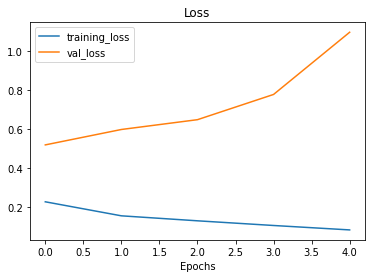

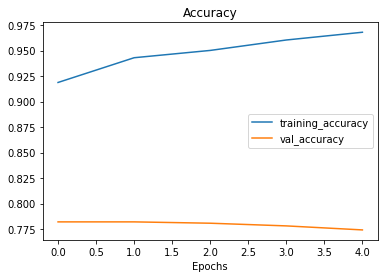

In [52]:
plot_loss_curves(model_2_history)

In [53]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.7133394e-03],
       [7.8906161e-01],
       [9.9982327e-01],
       [3.3463173e-02],
       [3.8865957e-04],
       [9.9972302e-01],
       [9.8003930e-01],
       [9.9990177e-01],
       [9.9983549e-01],
       [9.8584765e-01]], dtype=float32)

In [54]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.773929667242299,
 'recall': 0.7742782152230971,
 'f1': 0.7739104980298515}

In [56]:
np.array(list(model_2_results)) > np.array(list(model_1_results))

array([False, False, False, False])

In [57]:
np.array(list(model_2_results)) > np.array(list(baseline_results))

array([False, False, False, False])

## model_3 GRU model

In [58]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.GlobalAveragePooling1D(name='global_aaverage_pooling_1d')(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_gru')

model_3.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [59]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_3_gru')])

Saving TensorBoard log files to: model_logs/model_3_gru/20230304-110936
Epoch 1/5
215/215 [==============================] - 12s 41ms/step - loss: 0.1600 - accuracy: 0.9383 - val_loss: 0.7712 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0815 - accuracy: 0.9699 - val_loss: 1.0014 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0699 - accuracy: 0.9712 - val_loss: 0.9389 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0563 - accuracy: 0.9765 - val_loss: 0.9915 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0517 - accuracy: 0.9777 - val_loss: 1.1584 - val_accuracy: 0.7730


In [60]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[2.5232213e-03],
       [7.2691554e-01],
       [9.9987495e-01],
       [1.2679955e-01],
       [8.5891654e-05],
       [9.9984062e-01],
       [9.4787121e-01],
       [9.9994588e-01],
       [9.9990976e-01],
       [5.2902246e-01]], dtype=float32)

In [61]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

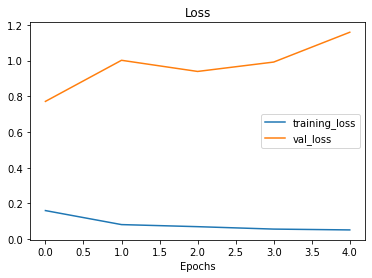

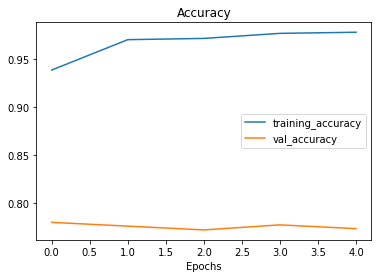

In [62]:
plot_loss_curves(model_3_history)

In [63]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7731790030340066,
 'recall': 0.7729658792650919,
 'f1': 0.7717707641179984}

In [64]:
np.array(list(model_3_results)) > np.array(list(baseline_results))

array([False, False, False, False])

## model_4_bidirectional lstm 

In [65]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_3_bidirectional')

model_4.compile(loss='binary_crossentropy', 
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_4.summary()

Model: "model_3_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [66]:
model_4_history = model_4.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_3_bidirectional')])

Saving TensorBoard log files to: model_logs/model_3_bidirectional/20230304-111001
Epoch 1/5
215/215 [==============================] - 20s 51ms/step - loss: 0.1037 - accuracy: 0.9645 - val_loss: 1.0492 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0527 - accuracy: 0.9793 - val_loss: 1.0452 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0461 - accuracy: 0.9790 - val_loss: 1.3140 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0414 - accuracy: 0.9790 - val_loss: 1.4486 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0415 - accuracy: 0.9809 - val_loss: 1.4965 - val_accuracy: 0.7664


In [67]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 5ms/step


array([[9.8323252e-04],
       [8.5204369e-01],
       [9.9993670e-01],
       [1.5060669e-01],
       [6.0351472e-06],
       [9.9980193e-01],
       [2.6647678e-01],
       [9.9996150e-01],
       [9.9994552e-01],
       [3.3309677e-01]], dtype=float32)

In [68]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [69]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7681630705252752,
 'recall': 0.7664041994750657,
 'f1': 0.7641523881052159}

In [70]:
np.array(list(model_4_results)) > np.array(list(baseline_results))

array([False, False, False, False])

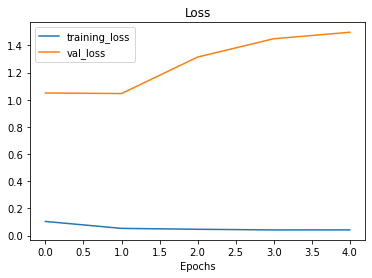

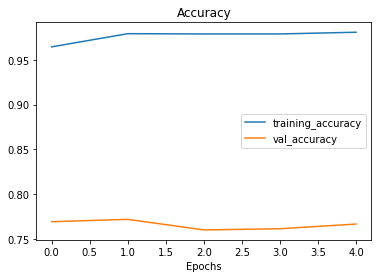

In [71]:
plot_loss_curves(model_4_history)

## model_5_conv1d

In [72]:
embedding_test = embedding(text_vectorizer(['This is a test sentence!']))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=1,
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04259454, -0.00817354, -0.06648919, ..., -0.01996244,
          0.0169421 , -0.01434864],
        [ 0.04118962, -0.0192515 , -0.00689555, ...,  0.04245692,
          0.05344893,  0.03643667],
        [-0.0127938 , -0.02273045,  0.0400281 , ..., -0.00898353,
          0.0036203 , -0.02044884],
        ...,
        [ 0.01279924, -0.02257109,  0.0066136 , ...,  0.00127255,
         -0.03172246,  0.00493391],
        [ 0.01279924, -0.02257109,  0.0066136 , ...,  0.00127255,
         -0.03172246,  0.00493391],
        [ 0.01279924, -0.02257109,  0.0066136 , ...,  0.00127255,
         -0.03172246,  0.00493391]]], dtype=float32)>

In [74]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.04354683, 0.        , 0.        ,
         0.        , 0.        , 0.08002064, 0.01232644, 0.13108194,
         0.03728365, 0.        , 0.03647283, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.01637948,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.02136635, 0.        , 0.06718972,
         0.02645002, 0.        ],
        [0.10094348, 0.        , 0.        , 0.        , 0.03001123,
         0.01959913, 0.01332945, 0.        , 0.01103871, 0.03066136,
         0.        , 0.        , 0.06565441, 0.        , 0.        ,
         0.02095511, 0.        , 0.        , 0.        , 0.01836243,
         0.        , 0.05357013, 0.05291929, 0.0428542 , 0.04459015,
         0.0149945 , 0.        , 0.00468057, 0.        , 0.        ,
         0.01445884, 0.        ],
        [0.00285978, 0.        , 0.        , 0.0103

In [75]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.10094348, 0.        , 0.04354683, 0.01037669, 0.03001123,
        0.03230442, 0.02273976, 0.08002064, 0.04423895, 0.13108194,
        0.07733448, 0.06724617, 0.06565441, 0.02443831, 0.00526843,
        0.02095511, 0.03868117, 0.08720983, 0.        , 0.02425967,
        0.        , 0.05357013, 0.05291929, 0.04948473, 0.05942252,
        0.0149945 , 0.05597311, 0.06510091, 0.        , 0.06718972,
        0.02645002, 0.        ]], dtype=float32)>

In [76]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D(name='global_max_pool_1d')(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')

model_5.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pool_1d (GlobalM  (None, 32)               0         
 axPooling1D)                                                    
                                                                 
 dense_4 (Dense)             (None, 1)              

In [77]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_5_conv1d')])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20230304-111040
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.1468 - accuracy: 0.9548 - val_loss: 0.8124 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0784 - accuracy: 0.9724 - val_loss: 0.9590 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0626 - accuracy: 0.9761 - val_loss: 1.0690 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0553 - accuracy: 0.9768 - val_loss: 1.1609 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0512 - accuracy: 0.9774 - val_loss: 1.1796 - val_accuracy: 0.7677


In [78]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.6827849e-01],
       [8.7204075e-01],
       [9.9990249e-01],
       [7.1406186e-02],
       [5.0019917e-08],
       [9.9803251e-01],
       [9.5591354e-01],
       [9.9997640e-01],
       [9.9999869e-01],
       [5.4803908e-01]], dtype=float32)

In [79]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [80]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.77165354330708,
 'precision': 0.7686883789989795,
 'recall': 0.7677165354330708,
 'f1': 0.7659262393850468}

In [81]:
np.array(list(model_5_results)) > np.array(list(baseline_results))

array([False, False, False, False])

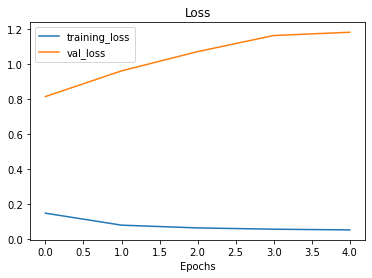

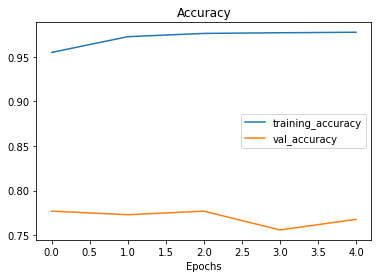

In [82]:
plot_loss_curves(model_5_history)

## model_6 transfer learning pretrainerd sentence encoder (USE)

In [83]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([random_sentence])
embed_samples[0, :50], embed_samples.shape

(<tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([ 0.04257242, -0.05241947, -0.00851213,  0.04140467,  0.05887054,
         0.0737134 ,  0.04065397,  0.0220241 , -0.06748408, -0.06217061,
         0.00503445,  0.06706823,  0.00509877, -0.01064229,  0.01423124,
        -0.07534585, -0.04722645, -0.0767685 , -0.07327614, -0.05025969,
         0.0011103 ,  0.04331254, -0.00098697, -0.00128495,  0.00733768,
         0.04108219,  0.01315051, -0.04819573, -0.02768813, -0.0005812 ,
        -0.06662407,  0.0675215 , -0.04614674,  0.04235661,  0.07151278,
         0.02235299, -0.06382091,  0.06525308, -0.06375543,  0.03104223,
        -0.05670599, -0.00920155, -0.01650199, -0.05386883, -0.05994451,
         0.01957094, -0.01713569, -0.03024884, -0.03636312, -0.00926879],
       dtype=float32)>, TensorShape([1, 512]))

In [84]:
embed_samples, embed_samples.shape

(<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
 array([[ 4.25724201e-02, -5.24194725e-02, -8.51213094e-03,
          4.14046720e-02,  5.88705428e-02,  7.37133995e-02,
          4.06539664e-02,  2.20240951e-02, -6.74840808e-02,
         -6.21706061e-02,  5.03444672e-03,  6.70682266e-02,
          5.09876851e-03, -1.06422938e-02,  1.42312441e-02,
         -7.53458515e-02, -4.72264513e-02, -7.67685026e-02,
         -7.32761398e-02, -5.02596907e-02,  1.11030438e-03,
          4.33125421e-02, -9.86973057e-04, -1.28495193e-03,
          7.33768381e-03,  4.10821922e-02,  1.31505141e-02,
         -4.81957346e-02, -2.76881307e-02, -5.81198547e-04,
         -6.66240677e-02,  6.75214976e-02, -4.61467430e-02,
          4.23566103e-02,  7.15127811e-02,  2.23529898e-02,
         -6.38209134e-02,  6.52530789e-02, -6.37554303e-02,
          3.10422331e-02, -5.67059927e-02, -9.20154806e-03,
         -1.65019892e-02, -5.38688302e-02, -5.99445067e-02,
          1.95709448e-02, -1.71356946e-02, -3.024

In [85]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [86]:
model_6 = models.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

model_6.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [87]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
model_6_history = model_6.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_6_USE')])

Saving TensorBoard log files to: model_logs/model_6_USE/20230304-111128
Epoch 1/5
215/215 [==============================] - 15s 28ms/step - loss: 0.5088 - accuracy: 0.7752 - val_loss: 0.4451 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.4145 - accuracy: 0.8161 - val_loss: 0.4338 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3999 - accuracy: 0.8232 - val_loss: 0.4383 - val_accuracy: 0.8005
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3908 - accuracy: 0.8262 - val_loss: 0.4258 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3845 - accuracy: 0.8333 - val_loss: 0.4224 - val_accuracy: 0.8163


In [89]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[0.20873436],
       [0.8151461 ],
       [0.9924388 ],
       [0.23449475],
       [0.7855484 ],
       [0.7652291 ],
       [0.9879187 ],
       [0.9885565 ],
       [0.95285827],
       [0.09976693]], dtype=float32)

In [90]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1': 0.8153469807013113}

In [92]:
np.array(list(model_6_results)) > np.array(list(baseline_results))

array([False, False, False, False])

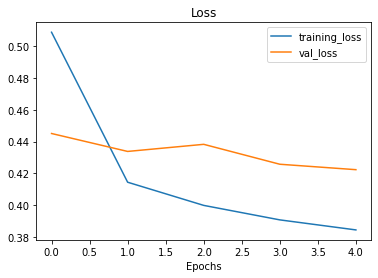

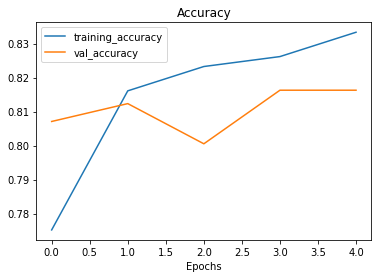

In [93]:
plot_loss_curves(model_6_history)

## model_7 tf hub pretrained USE with 10% data
* not samping from train-df_shuffled because information leakage occurs when validation data is present in the sampled training data

In [94]:
train_df_shuffled.head(), train_df_shuffled['target'].value_counts()

(        id      keyword               location  \
 2644  3796  destruction                    NaN   
 2227  3185       deluge                    NaN   
 5448  7769       police                     UK   
 132    191   aftershock                    NaN   
 6845  9810       trauma  Montgomery County, MD   
 
                                                    text  target  
 2644  So you have a new weapon that can cause un-ima...       1  
 2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  
 5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1  
 132   Aftershock back to school kick off was great. ...       0  
 6845  in response to trauma Children of Addicts deve...       0  , 0    4342
 1    3271
 Name: target, dtype: int64)

In [95]:
train_10_percent_split = int(.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [96]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [97]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name='tfhub_sentence_encoder_10_percent')])

Saving TensorBoard log files to: model_logs/tfhub_sentence_encoder_10_percent/20230304-111228
Epoch 1/5
22/22 [==============================] - 10s 148ms/step - loss: 0.6712 - accuracy: 0.6861 - val_loss: 0.6491 - val_accuracy: 0.7454
Epoch 2/5
22/22 [==============================] - 1s 62ms/step - loss: 0.5987 - accuracy: 0.8117 - val_loss: 0.5873 - val_accuracy: 0.7756
Epoch 3/5
22/22 [==============================] - 1s 48ms/step - loss: 0.5229 - accuracy: 0.8204 - val_loss: 0.5358 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 1s 43ms/step - loss: 0.4651 - accuracy: 0.8292 - val_loss: 0.5023 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 42ms/step - loss: 0.4212 - accuracy: 0.8394 - val_loss: 0.4896 - val_accuracy: 0.7769


In [99]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 20ms/step


array([[0.20029034],
       [0.58460546],
       [0.92743534],
       [0.3722914 ],
       [0.50932777],
       [0.6909144 ],
       [0.9054648 ],
       [0.8318805 ],
       [0.8454309 ],
       [0.16857909]], dtype=float32)

In [100]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7775711689884918,
 'recall': 0.7769028871391076,
 'f1': 0.7754662769426549}

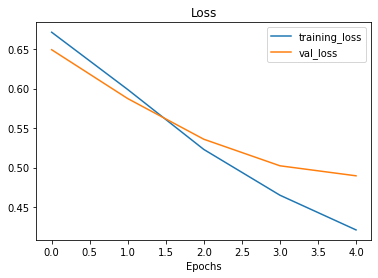

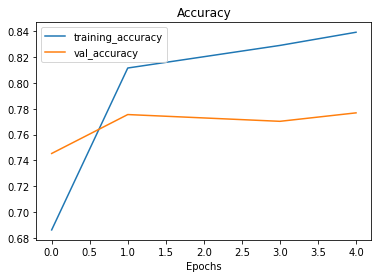

In [102]:
plot_loss_curves(model_7_history)

In [103]:
np.array(list(model_7_results)) > np.array(list(baseline_results))

array([False, False, False, False])

# compare the models

In [104]:
all_model_results = pd.DataFrame(
    {'0-baseline':baseline_results,
     '1-FNN':model_1_results,
     '2-LSTM':model_2_results,
     '3-GRU':model_3_results,
     '4-Bidirectional':model_4_results,
     '5-Conv1D':model_5_results,
     '6-USE':model_6_results,
     '7-USE_10_percent_data':model_7_results}
)
all_model_results = all_model_results.transpose()

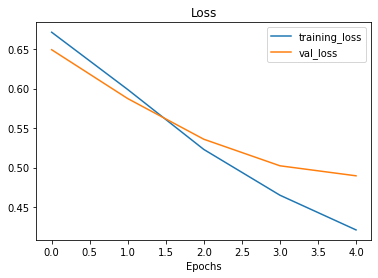

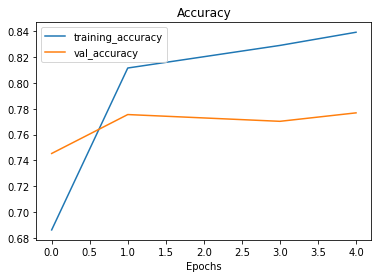

In [105]:
plot_loss_curves(model_7_history)

In [106]:
# all_model_results['accuracy'] /= 100
# all_model_results

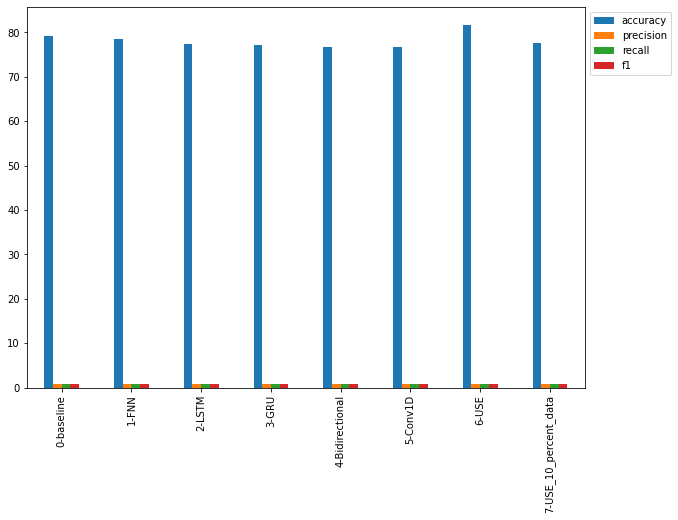

In [107]:
# plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

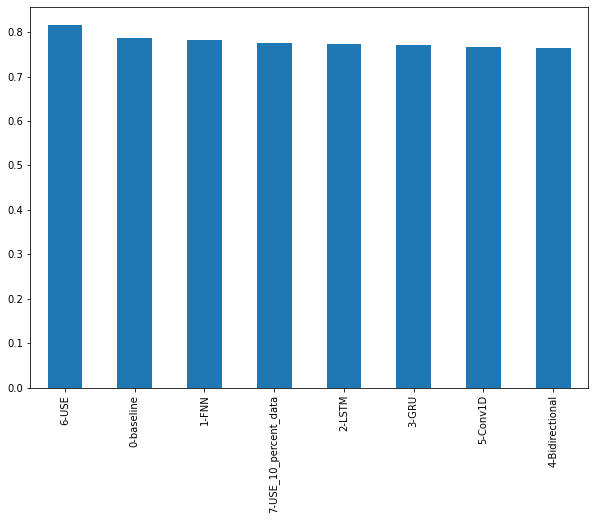

In [108]:
# sort f1 score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
--name "kaggle_introduction_to_nlp_models" \
--description "Different experiments and different models on kaggle introduction to nlp dataset with different sizes" \
--one_shot

* Done. View your TensorBoard at https://tensorboard.dev/experiment/Qka29ePnQW2a4mzhVW3cOw/

In [110]:
!tensorboard dev list

2023-03-04 11:18:23.818221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-04 11:18:23.818324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-04 11:18:23.818343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/j7lka3ieQm2AP5VxRDRdCg/
	Name                 kaggle_introduction_to_nlp_models
	Description          Different experiments and diff

In [111]:
# !tensorboard dev delete --experiment_id 

# save the model

In [112]:
model_6.save('models/tfhub_USE_model_all_data.h5')

In [113]:
model = models.load_model('models/tfhub_USE_model_all_data.h5',
                          custom_objects={'KerasLayer':hub.KerasLayer})

In [114]:
model.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [115]:
model_results = model.evaluate(val_sentences, val_labels)
model_results

24/24 [==============================] - 1s 16ms/step - loss: 0.4224 - accuracy: 0.8163


[0.42235293984413147, 0.8162729740142822]

In [116]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1': 0.8153469807013113}

In [117]:
model_6.save('models/tfhub_USE_model_all_data')

In [118]:
model = models.load_model('models/tfhub_USE_model_all_data')
model.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [119]:
model_results = model.evaluate(val_sentences, val_labels)
model_results

24/24 [==============================] - 1s 17ms/step - loss: 0.4224 - accuracy: 0.8163


[0.4223529100418091, 0.8162729740142822]

In [120]:
pred_probs = model.predict(val_sentences)
pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.2087344 ],
       [0.81514615],
       [0.9924388 ],
       [0.23449475],
       [0.7855484 ],
       [0.7652291 ],
       [0.9879187 ],
       [0.98855644],
       [0.95285827],
       [0.09976693]], dtype=float32)

In [121]:
preds = tf.squeeze(tf.round(pred_probs))
preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

# most wrong prediction

In [122]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip "08_model_6_USE_feature_extractor.zip"

--2023-03-04 11:19:10--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   147MB/s    in 7.3s    

2023-03-04 11:19:18 (125 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [123]:
model_pretrained = tf.keras.models.load_model('/content/08_model_6_USE_feature_extractor')

In [124]:
model_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [125]:
model_pretrained_pred_probs = model_pretrained.predict(val_sentences)
model_pretrained_pred_probs[:10]

24/24 [==============================] - 2s 21ms/step


array([[0.1597574 ],
       [0.747162  ],
       [0.98874855],
       [0.19622944],
       [0.7078079 ],
       [0.7096748 ],
       [0.98190695],
       [0.9810662 ],
       [0.94574374],
       [0.08504029]], dtype=float32)

In [126]:
model_pretrained_preds = tf.squeeze(tf.round(model_pretrained_pred_probs))
model_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [127]:
val_sentences.shape, val_labels.shape, model_pretrained_pred_probs.shape

((762,), (762,), (762, 1))

In [128]:
val_df = pd.DataFrame({
    'text':val_sentences,
    'target':val_labels,
    'pred':model_pretrained_preds,
    "pred_prob":tf.squeeze(model_pretrained_pred_probs),
})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [129]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong.head(10) # FP

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [130]:
most_wrong.tail() # FN

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [131]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, pred: {pred}, prob: {pred_prob:.2f}\n')
  print(f'Text: \n{text}\n')
  print('----\n\n')

Target: 0, pred: 1.0, prob: 0.91

Text: 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----


Target: 0, pred: 1.0, prob: 0.88

Text: 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----


Target: 0, pred: 1.0, prob: 0.85

Text: 
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----


Target: 0, pred: 1.0, prob: 0.84

Text: 
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----


Target: 0, pred: 1.0, prob: 0.83

Text: 
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----


Target: 0, pred: 1.0, prob: 0.81

Text: 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----


Target: 0, pred: 1.0, prob: 0.81

Text: 
[55436] 1950 LIONEL TR

In [132]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, pred: {pred}, prob: {pred_prob:.2f}\n')
  print(f'Text: \n{text}\n')
  print('----\n\n')

Target: 1, pred: 0.0, prob: 0.07

Text: 
@DavidVonderhaar At least you were sincere ??

----


Target: 1, pred: 0.0, prob: 0.06

Text: 
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----


Target: 1, pred: 0.0, prob: 0.05

Text: 
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----


Target: 1, pred: 0.0, prob: 0.05

Text: 
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----


Target: 1, pred: 0.0, prob: 0.05

Text: 
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----


Target: 1, pred: 0.0, prob: 0.04

Text: 
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----


Target: 1, pred: 0.0, prob: 0.04

Text: 
I get to smoke my shit in peace

----


Target: 1, pred: 0.0, p

# predict and visualize test data

In [133]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [134]:
test_sentences = test_df['text'].to_list()
len(test_sentences), test_sentences[:10]

(3263,
 ['Just happened a terrible car crash',
  'Heard about #earthquake is different cities, stay safe everyone.',
  'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
  'Apocalypse lighting. #Spokane #wildfires',
  'Typhoon Soudelor kills 28 in China and Taiwan',
  "We're shaking...It's an earthquake",
  "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
  'Hey! How are you?',
  'What a nice hat?',
  'Fuck off!'])

In [135]:
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f'Pred: {pred}, Prob: {pred_prob}\n')
  print(f'Text: \n{test_sample}\n')
  print("----\n\n")

1/1 [==============================] - 0s 117ms/step
Pred: 0.0, Prob: 0.07261404395103455

Text: 
Patent Pending Stream 'Armageddon' EP http://t.co/BOuaJqi3Lf

----


1/1 [==============================] - 0s 55ms/step
Pred: 1.0, Prob: 0.8494228720664978

Text: 
The meltdown I'm currently witnessing makes it seem like a delayed flight is a true anomaly instead of y'know the expected outcome.

----


1/1 [==============================] - 0s 53ms/step
Pred: 0.0, Prob: 0.15127582848072052

Text: 
World of Warcraft: Legion Revealed at gamescom: The Burning Legion returns to bring destruction to Azeroth onc... http://t.co/7n9qqkQIl3

----


1/1 [==============================] - 0s 61ms/step
Pred: 1.0, Prob: 0.9758627414703369

Text: 
#Children traumatised after the Nepal earthquake are educated on coping mechanisms.   http://t.co/UbwDBydK1a

----


1/1 [==============================] - 0s 64ms/step
Pred: 1.0, Prob: 0.9699904918670654

Text: 
#science Now that a piece of wreckage from fli

# twitter

In [216]:
tweets = ["""Fun fact of the day: http://zerotomastery.io gets well over 1,000,000+ visitors a month. Jump on the bandwagon while it's still early. It won't be a "well kept secret of the few" for very much longer...""", 
          """The station master involved in Greece’s worst-ever train disaster will appear in court on Saturday, as mass protests broke out over the crash that killed at least 57 people https://aje.io/515ygl"""]
tweet_labels = [0, 1]

tweet_preds = give_predictions(model, tweets)
tweet_preds        

1/1 [==============================] - 0s 43ms/step


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1], dtype=int32)>

# the speed/scoer tradeoff

In [137]:
model_6_results, baseline_results

({'accuracy': 81.62729658792651,
  'precision': 0.8170007401548035,
  'recall': 0.8162729658792651,
  'f1': 0.8153469807013113},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

In [138]:
import time

# time taken for model to predict
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [139]:
model_6_total_time, model_6_time_per_pred = pred_timer(model=model_pretrained, 
                                                            samples=val_sentences)
model_6_total_time, model_6_time_per_pred

24/24 [==============================] - 0s 15ms/step


(0.5285207140000239, 0.0006935967375328397)

In [140]:
baseline_total_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                        samples=val_sentences)
baseline_total_time, baseline_time_per_pred

(0.0524526080000669, 6.88354435696416e-05)

In [141]:
model_pretrained_results = calculate_results(y_true=val_labels,
                  y_pred=model_pretrained_preds)
model_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1_score')

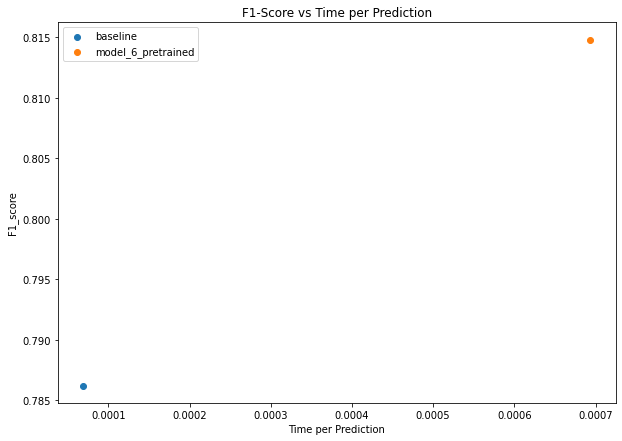

In [142]:
import matplotlib.pyplot as plt

# plot the f1_score and time_per_pred
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_pretrained_results['f1'], label='model_6_pretrained')
plt.legend()
plt.title('F1-Score vs Time per Prediction')
plt.xlabel('Time per Prediction')
plt.ylabel('F1_score')

# model_8 sequential api FFN

In [143]:
model_8 = models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model_8.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [144]:
model_8_seq_history = model_8.fit(train_sentences, 
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name='model_8_fnn_sequential')])

Saving TensorBoard log files to: model_logs/model_8_fnn_sequential/20230304-111959
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.4938 - accuracy: 0.8613 - val_loss: 0.4983 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2895 - accuracy: 0.9219 - val_loss: 0.4646 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2110 - accuracy: 0.9378 - val_loss: 0.4752 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1684 - accuracy: 0.9531 - val_loss: 0.5015 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1411 - accuracy: 0.9584 - val_loss: 0.5273 - val_accuracy: 0.7769


In [145]:
model_8_pred_probs = model_8.predict(val_sentences)
model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_pred_probs[:10], model_8_preds[:10]

24/24 [==============================] - 0s 2ms/step


(array([[0.33124462],
        [0.802306  ],
        [0.99673307],
        [0.18884729],
        [0.01462649],
        [0.95779216],
        [0.8232722 ],
        [0.99822575],
        [0.99443805],
        [0.4442903 ]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>)

In [147]:
model_8_results = calculate_results(y_true=val_labels,
                                    y_pred=model_8_preds)
all_model_results = all_model_results.transpose()
all_model_results['8-fnn_seq'] = model_8_results.values()
all_model_results

,0-baseline,1-FNN,2-LSTM,3-GRU,4-Bidirectional,5-Conv1D,6-USE,7-USE_10_percent_data,8-fnn_seq
accuracy,79.265092,78.608924,77.427822,77.296588,76.640420,76.771654,81.627297,77.690289,77.690289
precision,0.811139,0.790328,0.773930,0.773179,0.768163,0.768688,0.817001,0.777571,0.778187
recall,0.792651,0.786089,0.774278,0.772966,0.766404,0.767717,0.816273,0.776903,0.776903
f1,0.786219,0.783297,0.773910,0.771771,0.764152,0.765926,0.815347,0.775466,0.775124


# mode_9 lstm sequential

In [148]:
model_9 = models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
])

model_9.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [149]:
model_9_lstm_seq_history = model_9.fit(train_sentences,
                                       train_labels,
                                       epochs=5,
                                       validation_data=(val_sentences, val_labels),
                                       callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                              experiment_name='model_9_lstm_sequential')])

Saving TensorBoard log files to: model_logs/model_9_lstm_sequential/20230304-112202
Epoch 1/5
215/215 [==============================] - 12s 44ms/step - loss: 0.1085 - accuracy: 0.9629 - val_loss: 1.2250 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0546 - accuracy: 0.9774 - val_loss: 0.9956 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0423 - accuracy: 0.9809 - val_loss: 1.4025 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0416 - accuracy: 0.9803 - val_loss: 1.3588 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0351 - accuracy: 0.9831 - val_loss: 1.5494 - val_accuracy: 0.7743


In [150]:
model_9_pred_probs = model_9.predict(val_sentences)
model_9_preds =tf.squeeze(tf.round(model_9_pred_probs))
model_9_pred_probs[:10], model_9_preds[:10]

24/24 [==============================] - 1s 3ms/step


(array([[2.9696219e-04],
        [8.4732312e-01],
        [9.9981946e-01],
        [8.3562709e-02],
        [4.4328390e-05],
        [9.9949384e-01],
        [5.8285606e-01],
        [9.9985683e-01],
        [9.9982661e-01],
        [9.6949673e-01]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>)

In [151]:
model_9_results = calculate_results(y_true=val_labels,
                                    y_pred=model_9_preds)
all_model_results['9-lstm_seq'] = model_9_results.values()
all_model_results

,0-baseline,1-FNN,2-LSTM,3-GRU,4-Bidirectional,5-Conv1D,6-USE,7-USE_10_percent_data,8-fnn_seq,9-lstm_seq
accuracy,79.265092,78.608924,77.427822,77.296588,76.640420,76.771654,81.627297,77.690289,77.690289,77.427822
precision,0.811139,0.790328,0.773930,0.773179,0.768163,0.768688,0.817001,0.777571,0.778187,0.775286
recall,0.792651,0.786089,0.774278,0.772966,0.766404,0.767717,0.816273,0.776903,0.776903,0.774278
f1,0.786219,0.783297,0.773910,0.771771,0.764152,0.765926,0.815347,0.775466,0.775124,0.772597


# model_10 conv1d seq

In [152]:
model_10 = models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model_10.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])

model_10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089
No

In [153]:
model_10_conv1d_history = model_10.fit(train_sentences, 
                                       train_labels,
                                       epochs=5,
                                       validation_data=(val_sentences, val_labels),
                                       callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                              experiment_name='model_10_conv1d_sequential')])

Saving TensorBoard log files to: model_logs/moedl_10_conv1d_sequential/20230304-112226
Epoch 1/5
215/215 [==============================] - 11s 42ms/step - loss: 0.0960 - accuracy: 0.9667 - val_loss: 0.9647 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0621 - accuracy: 0.9766 - val_loss: 1.0930 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0519 - accuracy: 0.9788 - val_loss: 1.1782 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0476 - accuracy: 0.9801 - val_loss: 1.2627 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0464 - accuracy: 0.9778 - val_loss: 1.3304 - val_accuracy: 0.7638


In [154]:
model_10_pred_probs = model_10.predict(val_sentences)
model_10_preds = tf.squeeze(tf.round(model_10_pred_probs))
model_10_pred_probs[:10], model_10_preds[:10]

24/24 [==============================] - 0s 3ms/step


(array([[1.4215782e-02],
        [5.3356034e-01],
        [9.9998820e-01],
        [5.7617549e-02],
        [1.0868900e-08],
        [9.9841142e-01],
        [9.9059522e-01],
        [9.9998033e-01],
        [9.9999988e-01],
        [8.4634167e-01]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>)

In [155]:
model_10_results = calculate_results(y_true=val_labels, 
                                     y_pred=model_10_preds)
all_model_results['10-conv1d_seq'] = model_10_results.values()
all_model_results

,0-baseline,1-FNN,2-LSTM,3-GRU,4-Bidirectional,5-Conv1D,6-USE,7-USE_10_percent_data,8-fnn_seq,9-lstm_seq,10-conv1d_seq
accuracy,79.265092,78.608924,77.427822,77.296588,76.640420,76.771654,81.627297,77.690289,77.690289,77.427822,76.377953
precision,0.811139,0.790328,0.773930,0.773179,0.768163,0.768688,0.817001,0.777571,0.778187,0.775286,0.764216
recall,0.792651,0.786089,0.774278,0.772966,0.766404,0.767717,0.816273,0.776903,0.776903,0.774278,0.763780
f1,0.786219,0.783297,0.773910,0.771771,0.764152,0.765926,0.815347,0.775466,0.775124,0.772597,0.762258


# model_11 retrain on 10% data

In [156]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_11 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_11.fit(train_sentences_10_percent,
            train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [157]:
baseline_preds_10_percent = model_11.predict(val_sentences)
baseline_preds_10_percent[:10]

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [158]:
baseline_results_10_percent = calculate_results(y_true=val_labels,
                                                 y_pred=baseline_preds_10_percent)
baseline_results_10_percent

{'accuracy': 70.20997375328083,
 'precision': 0.7599524002753854,
 'recall': 0.7020997375328084,
 'f1': 0.6736831571468213}

In [159]:
import numpy as np
np.array(list(baseline_results_10_percent)) > np.array(list(model_7_results))

array([False, False, False, False])

In [160]:
all_model_results

,0-baseline,1-FNN,2-LSTM,3-GRU,4-Bidirectional,5-Conv1D,6-USE,7-USE_10_percent_data,8-fnn_seq,9-lstm_seq,10-conv1d_seq
accuracy,79.265092,78.608924,77.427822,77.296588,76.640420,76.771654,81.627297,77.690289,77.690289,77.427822,76.377953
precision,0.811139,0.790328,0.773930,0.773179,0.768163,0.768688,0.817001,0.777571,0.778187,0.775286,0.764216
recall,0.792651,0.786089,0.774278,0.772966,0.766404,0.767717,0.816273,0.776903,0.776903,0.774278,0.763780
f1,0.786219,0.783297,0.773910,0.771771,0.764152,0.765926,0.815347,0.775466,0.775124,0.772597,0.762258


In [161]:
all_model_results['11-nb_10_percent'] = baseline_results_10_percent.values()
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0-baseline,79.265092,0.811139,0.792651,0.786219
1-FNN,78.608924,0.790328,0.786089,0.783297
2-LSTM,77.427822,0.773930,0.774278,0.773910
3-GRU,77.296588,0.773179,0.772966,0.771771
4-Bidirectional,76.640420,0.768163,0.766404,0.764152
5-Conv1D,76.771654,0.768688,0.767717,0.765926
6-USE,81.627297,0.817001,0.816273,0.815347
7-USE_10_percent_data,77.690289,0.777571,0.776903,0.775466
8-fnn_seq,77.690289,0.778187,0.776903,0.775124
9-lstm_seq,77.427822,0.775286,0.774278,0.772597


# compare the models

In [162]:
all_model_results['accuracy'] /= 100
all_model_results

,accuracy,precision,recall,f1
0-baseline,0.792651,0.811139,0.792651,0.786219
1-FNN,0.786089,0.790328,0.786089,0.783297
2-LSTM,0.774278,0.773930,0.774278,0.773910
3-GRU,0.772966,0.773179,0.772966,0.771771
4-Bidirectional,0.766404,0.768163,0.766404,0.764152
5-Conv1D,0.767717,0.768688,0.767717,0.765926
6-USE,0.816273,0.817001,0.816273,0.815347
7-USE_10_percent_data,0.776903,0.777571,0.776903,0.775466
8-fnn_seq,0.776903,0.778187,0.776903,0.775124
9-lstm_seq,0.774278,0.775286,0.774278,0.772597


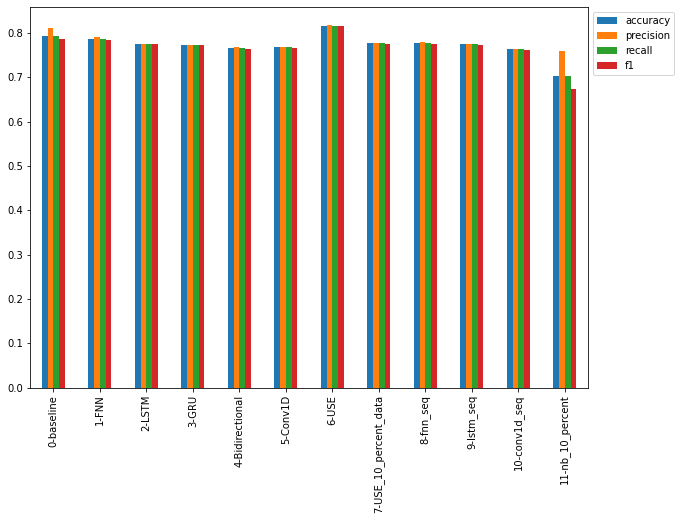

In [163]:
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

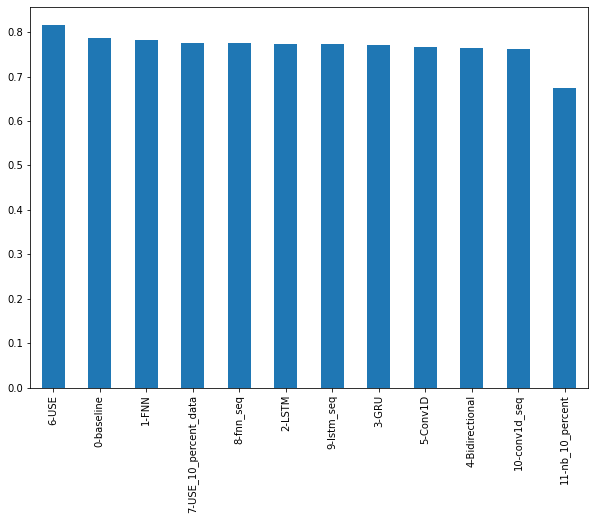

In [164]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

<AxesSubplot:>

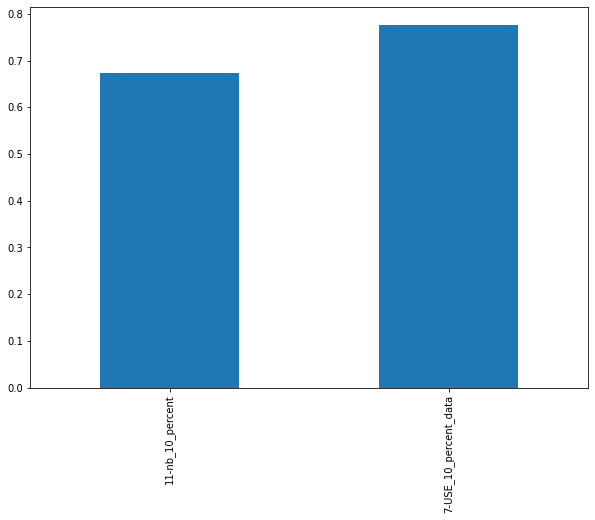

In [165]:
all_model_results.sort_values('f1', ascending=False)['f1'][['11-nb_10_percent', '7-USE_10_percent_data']].plot(kind='bar', figsize=(10, 7))

# fine tuning tfhub USE on 

In [166]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name='USE')

In [167]:
model_12 = tf.keras.models.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')   
], name='fine_tuned_USE')

model_12.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])

model_12.summary()

Model: "fine_tuned_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [168]:
model_12_feat_history = model_12.fit(train_sentences, 
                                     train_labels,
                                     epochs=5,
                                     validation_data=(val_sentences, val_labels),
                                     callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                            experiment_name='model_12_fine_tuned_USE')])

Saving TensorBoard log files to: model_logs/model_12_fine_tuned_USE/20230304-112301
Epoch 1/5
215/215 [==============================] - 178s 581ms/step - loss: 0.4506 - accuracy: 0.8011 - val_loss: 0.4323 - val_accuracy: 0.8189
Epoch 2/5
215/215 [==============================] - 34s 161ms/step - loss: 0.2414 - accuracy: 0.9069 - val_loss: 0.4777 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 29s 133ms/step - loss: 0.0788 - accuracy: 0.9734 - val_loss: 0.5732 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 25s 115ms/step - loss: 0.0390 - accuracy: 0.9863 - val_loss: 0.6663 - val_accuracy: 0.8071
Epoch 5/5
215/215 [==============================] - 23s 108ms/step - loss: 0.0257 - accuracy: 0.9904 - val_loss: 0.7618 - val_accuracy: 0.8071


In [169]:
model_12_pred_probs = model_12.predict(val_sentences)
model_12_preds = tf.squeeze(tf.round(model_12_pred_probs))
model_12_pred_probs[:10], model_12_preds[:10]

24/24 [==============================] - 1s 11ms/step


(array([[0.04552125],
        [0.9393482 ],
        [0.99963737],
        [0.0010623 ],
        [0.9114048 ],
        [0.99940133],
        [0.9994748 ],
        [0.9996202 ],
        [0.99943596],
        [0.00158536]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>)

In [170]:
model_12_results = calculate_results(y_true=val_labels,
                                     y_pred=model_12_preds)
all_model_results = all_model_results.transpose()
all_model_results['12-tfhub_USE_fine_tuned'] = model_12_results.values()

In [171]:
!tensorboard dev upload --logdir ./model_logs \
  --name 'nlp_models_comparison' \
  --description 'comparing models on kaggle introduction to nlp dataset' \
  --one_shot

2023-03-04 11:27:57.173976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-04 11:27:57.174733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-04 11:27:57.174760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/EbhNaVXuR2CAj9NA8KXwYw/

[2023-03-04T11:28:01] Started scanning logdir.
[2023-03-

* Done. View your TensorBoard at https://tensorboard.dev/experiment/M7YLVa1ESjq7yWaq4vVqDA/

In [172]:
all_model_results['12-tfhub_USE_fine_tuned']['accuracy'] /= 100

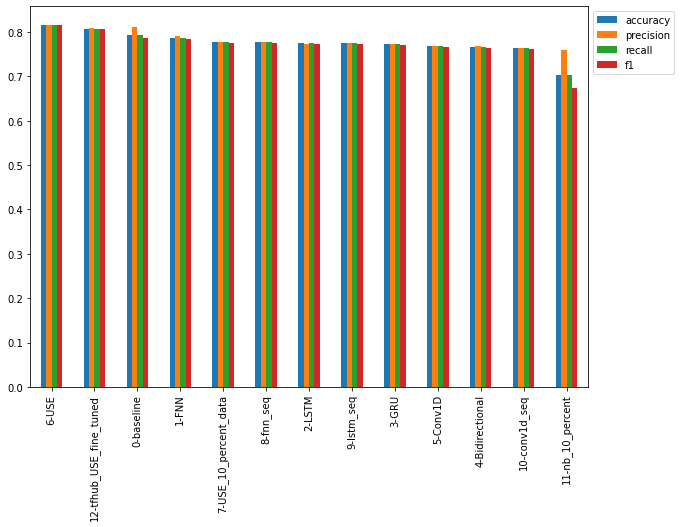

In [173]:
all_model_results.transpose().sort_values('f1', ascending=False).plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

# best model

* model_6: tfhub USE on all data

In [174]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [179]:
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [195]:
train_sentences, train_labels = train_df_shuffled['text'], train_df_shuffled['target']
test_sentences, test_id = test_df['text'], test_df['id']

In [196]:
model_6.compile(loss=losses.BinaryCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [197]:
best_model_history = model_6.fit(train_sentences,
                                 train_labels,
                                 epochs=5,
                                 callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                        experiment_name='best_model_tfhub_USE')])

Saving TensorBoard log files to: model_logs/best_model_tfhub_USE/20230304-115532
Epoch 1/5
238/238 [==============================] - 5s 12ms/step - loss: 0.3507 - accuracy: 0.8491
Epoch 2/5
238/238 [==============================] - 3s 14ms/step - loss: 0.3428 - accuracy: 0.8517
Epoch 3/5
238/238 [==============================] - 4s 18ms/step - loss: 0.3362 - accuracy: 0.8534
Epoch 4/5
238/238 [==============================] - 3s 12ms/step - loss: 0.3299 - accuracy: 0.8570
Epoch 5/5
238/238 [==============================] - 3s 12ms/step - loss: 0.3225 - accuracy: 0.8627


In [202]:
best_model_pred_probs = model_6.predict(test_sentences)
best_model_preds = tf.squeeze(tf.round(best_model_pred_probs))
best_model_preds = tf.cast(best_model_preds, tf.int32)
best_model_pred_probs[:10], best_model_preds[:10]

102/102 [==============================] - 2s 19ms/step


(array([[0.5542908 ],
        [0.9298332 ],
        [0.7399448 ],
        [0.95336854],
        [0.9892998 ],
        [0.574864  ],
        [0.04463106],
        [0.02236989],
        [0.04101484],
        [0.03589272]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)>)

In [203]:
submission = pd.DataFrame(
    {'id':test_id,
     'target':best_model_preds}
)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [204]:
## save to csv file
from google.colab import files

!mkdir 'results/'
submission.to_csv('results/USE_submission.csv', index=False)
files.download('results/USE_submission.csv')

mkdir: cannot create directory ‘results/’: File exists


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [205]:
len(test_id), len(test_sentences)

(3263, 3263)

# ensemble

In [206]:
def give_predictions(model, sentences):
  pred_probs = model.predict(sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds, tf.int32)
  return preds

In [209]:
ensemble_preds = pd.DataFrame({
    'lstm':give_predictions(model_2, test_sentences),
    'conv1d':give_predictions(model_5, test_sentences),
    'USE':give_predictions(model_6, test_sentences)
})
ensemble_preds

102/102 [==============================] - 1s 11ms/step


,lstm,conv1d,USE
0,1,1,1
1,0,0,1
2,1,1,1
3,0,1,1
4,1,1,1
...,...,...,...
3258,1,1,1
3259,1,1,1
3260,1,1,1
3261,1,1,1


In [210]:
ensemble_preds['ensemble'] = ensemble_preds.mode(axis=1)
ensemble_preds

,lstm,conv1d,USE,ensemble
0,1,1,1,1
1,0,0,1,0
2,1,1,1,1
3,0,1,1,1
4,1,1,1,1
...,...,...,...,...
3258,1,1,1,1
3259,1,1,1,1
3260,1,1,1,1
3261,1,1,1,1


# confusion_matrix of best_model on validation data

24/24 [==============================] - 1s 24ms/step


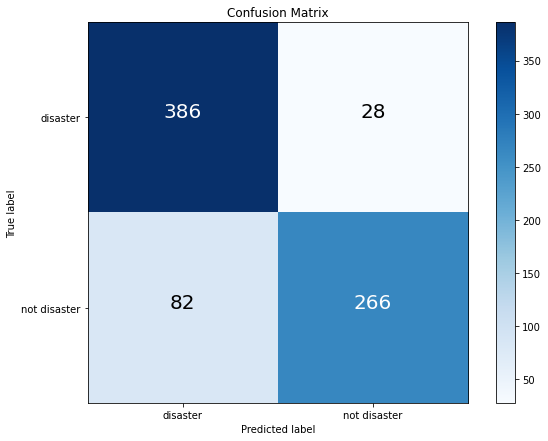

In [217]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=val_labels,
                      y_pred=give_predictions(model_6, val_sentences),
                      classes=['disaster', 'not disaster'],
                      figsize=(10, 7),
                      text_size=20)